In [27]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn as sk
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import pmdarima as pm

pd.options.mode.chained_assignment = None
sns.set()

In [28]:
hospital = pd.read_csv("Covid_bedRatio.csv", header=1)
hospital.rename(mapper={'state':'collection_week'}, axis=1, inplace=True)
hospital = hospital.iloc[1:]
hospital.set_index('collection_week', inplace=True)
hospital.index = pd.to_datetime(hospital.index)

In [29]:
hospital.head()

,AK,AL,AR,AS,AZ,CA,CO,CT,DC,DE,...,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
collection_week,,,,,,,,,,,,,,,,,,,,,
2020-07-31,0.033571,0.127481,0.217442,0.0,0.235131,0.123965,0.032439,0.018981,0.057798,0.032929,...,0.075014,0.184290,0.044624,0.082038,0.000000,0.010799,0.057122,0.041471,0.033476,0.021030
2020-08-07,0.027695,0.116080,0.214072,0.0,0.176308,0.111782,0.032178,0.016064,0.054433,0.028821,...,0.073361,0.151879,0.034257,0.077636,0.023404,0.010035,0.053284,0.050271,0.032575,0.016852
2020-08-14,0.029934,0.102887,0.086653,0.0,0.126893,0.103477,0.026083,0.014648,0.048163,0.029319,...,0.065914,0.125044,0.029294,0.073908,0.060106,0.010796,0.033769,0.049701,0.033764,0.014699
2020-08-21,0.028316,0.090916,0.074062,0.0,0.086526,0.091169,0.026288,0.016801,0.048181,0.035834,...,0.057382,0.101252,0.023719,0.068786,0.040957,0.000000,0.045304,0.043091,0.033355,0.013862
2020-08-28,0.023173,0.079947,0.061889,0.0,0.072333,0.077303,0.021203,0.019552,0.043219,0.038996,...,0.055527,0.087457,0.022730,0.072454,0.040957,0.000000,0.039413,0.035084,0.031281,0.004382


In [30]:
state_map = pd.read_csv('statemap.csv')
state_map.drop(columns=['Abbrev'], inplace=True)
state_map.head()
state = list(state_map.loc[:, 'State'])
code = list(state_map.loc[:, 'Code'])

state_map = dict(zip(code, state))

for i in zip(('VI', 'AS', 'MP', 'GU', 'PR'), ('Virgin Islands', 'American Samoa', 'Northern Mariana Islands', 'Guam', 'Puerto Rico')):
    state_map[i[0]] = i[1]

In [31]:
hospital.rename(columns=state_map, inplace=True)

In [32]:
covid_base = pd.read_csv('Wrangled_states.csv', index_col='date', parse_dates=True)

In [33]:
covid_base.head()

,state,cases,deaths,new_cases,percent_change
date,,,,,
2020-01-21,Washington,1,0.0,1.0,1.0
2020-01-22,Washington,1,0.0,0.0,0.0
2020-01-23,Washington,1,0.0,0.0,0.0
2020-01-24,Illinois,1,0.0,0.0,0.0
2020-01-24,Washington,1,0.0,0.0,0.0


In [34]:
covid = covid_base.pivot(columns='state', values='new_cases')
covid.fillna(value=0, inplace=True)

In [35]:
covid.head()

state,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,
2020-01-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Get State Features for Clustering

In [36]:
state_mean = covid.mean(axis=0)
state_median = covid.median(axis=0)
state_std = covid.std(axis=0)

state_features = pd.DataFrame([state_mean, state_median, state_std], index=['mean', 'median', 'standard_dev'])
state_features.head()

state,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
mean,381441.220930,-368495.875969,-35582.298450,632725.789406,-387615.552972,2.532281e+06,-2.399459e+06,-163161.033592,-161312.612403,-40186.257106,...,561110.421189,1.587586e+06,-1.933404e+06,-282515.687339,-18202.350129,500569.617571,-135262.240310,-239078.843669,382213.259690,-462987.401809
median,423966.500000,-421043.000000,0.000000,735707.500000,-480991.500000,3.145101e+06,-3.044402e+06,-150126.000000,-184184.500000,-43227.500000,...,626995.500000,1.798739e+06,-2.177494e+06,-344774.500000,-10690.500000,536673.500000,-189871.000000,-202522.500000,477784.500000,-551043.500000
standard_dev,313322.755155,296161.918202,69955.952503,538571.265498,315495.030807,2.166425e+06,2.033928e+06,167644.866123,129975.854528,36764.814574,...,480247.273377,1.308558e+06,1.599673e+06,232767.994663,23983.178310,437582.354231,98570.215894,230621.620735,304331.688634,388243.744555


In [37]:
state_mean = hospital.mean(axis=0)
state_median = hospital.median(axis=0)
state_std = hospital.std(axis=0)

state_features = pd.DataFrame([state_mean, state_median, state_std], index=['mean', 'median', 'standard_dev'])
state_features.head()

,Alaska,Alabama,Arkansas,American Samoa,Arizona,California,Colorado,Connecticut,District of Columbia,Delaware,...,Tennessee,Texas,Utah,Virginia,Virgin Islands,Vermont,Washington,Wisconsin,West Virginia,Wyoming
mean,0.056605,0.084748,0.081511,0.0,0.115142,0.096242,0.069675,0.058335,0.055310,0.068458,...,0.081284,0.109865,0.059219,0.073645,0.021902,0.013983,0.066034,0.063814,0.074846,0.057155
median,0.034912,0.066377,0.073720,0.0,0.095429,0.065643,0.055501,0.041737,0.050116,0.061601,...,0.059850,0.090192,0.055164,0.063335,0.000000,0.011308,0.054574,0.051752,0.048098,0.029751
standard_dev,0.045036,0.062648,0.051488,0.0,0.083830,0.084675,0.042545,0.049552,0.027134,0.045821,...,0.054329,0.064169,0.031942,0.040442,0.044325,0.013591,0.033961,0.047833,0.051835,0.049684


In [38]:
X = state_features.transpose().sort_index()
X.head()

,mean,median,standard_dev
Alabama,0.084748,0.066377,0.062648
Alaska,0.056605,0.034912,0.045036
American Samoa,0.000000,0.000000,0.000000
Arizona,0.115142,0.095429,0.083830
Arkansas,0.081511,0.073720,0.051488


In [39]:
X.describe()

,mean,median,standard_dev
count,56.000000,56.000000,56.000000
mean,0.069727,0.054015,0.048918
std,0.026351,0.022606,0.017403
min,0.000000,0.000000,0.000000
25%,0.058040,0.043514,0.042019
50%,0.072283,0.054869,0.049639
75%,0.082181,0.065180,0.055670
max,0.135156,0.106417,0.088637


In [40]:
# Scale data
scaler = MinMaxScaler()

scaled_X = scaler.fit_transform(X)

## Hierachical Clustering of States based on daily new cases of covid

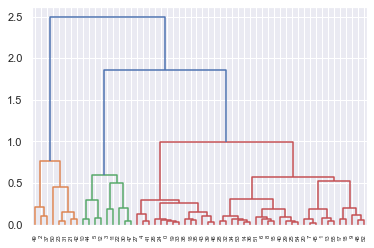

In [41]:
dend = sch.dendrogram(sch.linkage(scaled_X, method='ward'))
plt.axhline(y=4, color='b')

In [42]:
state_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
state_cluster.fit_predict(scaled_X)

array([3, 1, 0, 2, 3, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 3, 1, 1, 3, 1, 0,
       2, 0, 3, 1, 3, 3, 1, 1, 2, 0, 1, 3, 1, 3, 1, 0, 3, 3, 1, 3, 0, 3,
       2, 1, 3, 2, 1, 0, 0, 1, 1, 1, 1, 1], dtype=int64)

Text(0.5, 0, 'Standard Deviation')

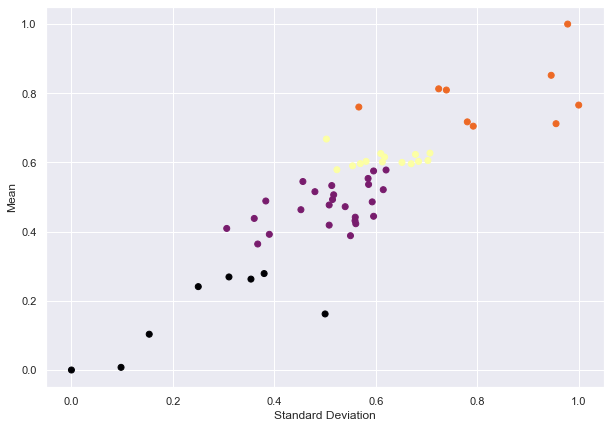

In [43]:
plt.figure(figsize=(10,7))
plt.scatter(scaled_X[:,2], scaled_X[:,0], c=state_cluster.labels_, cmap='inferno')
#plt.ylim(-1e6, 1e6)
#plt.xlim(right=1e6)
plt.ylabel('Mean')
plt.xlabel('Standard Deviation')

Text(0.5, 1.0, 'Mean by cluster')

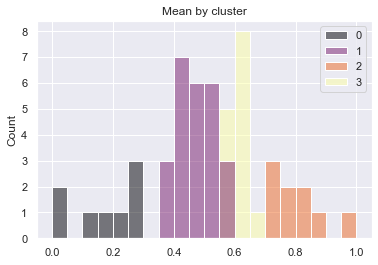

In [44]:
# Histogram of mean by cluster
sns.histplot(x=scaled_X[:,0], hue=state_cluster.labels_, palette='inferno', bins=20)
plt.title('Mean by cluster')

Text(0.5, 1.0, 'Median by cluster')

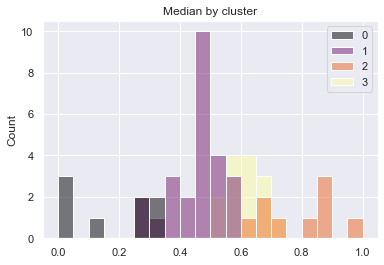

In [45]:
# Histogram of median by cluster
sns.histplot(x=scaled_X[:,1], hue=state_cluster.labels_, palette='inferno', bins=20)
plt.title('Median by cluster')

Text(0.5, 1.0, 'Standard Deviation by cluster')

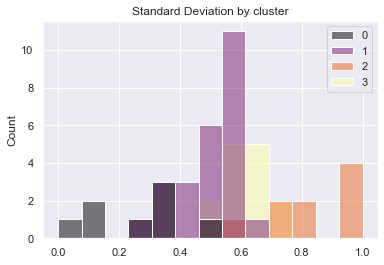

In [46]:
# Histogram of mean by cluster
sns.histplot(x=scaled_X[:,2], hue=state_cluster.labels_, palette='inferno')
plt.title('Standard Deviation by cluster')

# Now make time series model by cluster

In [47]:
# First resample covid data by week to match hospital data
covid_resample = covid.loc['2020-07-25':'2021-11-26']
covid_resample = covid_resample.resample(rule='W-FRI', convention='end').mean()

In [67]:
c1 = covid_resample.transpose().loc[state_cluster.labels_==2].transpose()
c1

state,Arizona,California,Florida,Georgia,Guam,Maryland,Nevada,South Carolina,Texas
date,,,,,,,,,
2020-07-31,1.631703e+05,4.365471e+05,4.303914e+05,-2.818721e+05,-1.591291e+05,82286.142857,19771.714286,65672.428571,3.183107e+05
2020-08-07,1.768476e+05,4.826496e+05,4.858259e+05,-3.148840e+05,-1.819846e+05,88290.142857,24797.857143,74929.428571,3.628413e+05
2020-08-14,1.842391e+05,5.339134e+05,5.314561e+05,-3.382474e+05,-2.046834e+05,93303.142857,28548.285714,82105.857143,4.026361e+05
2020-08-21,1.896730e+05,5.871799e+05,5.673927e+05,-3.556021e+05,-2.235359e+05,97575.857143,31740.000000,87213.000000,4.422974e+05
2020-08-28,1.935013e+05,6.242000e+05,5.924497e+05,-3.639246e+05,-2.402347e+05,101209.285714,34013.857143,92074.285714,4.702377e+05
...,...,...,...,...,...,...,...,...,...
2021-10-29,1.154007e+06,4.377299e+06,3.577029e+06,-2.047420e+06,-1.574746e+06,455637.142857,166046.857143,715317.000000,2.966165e+06
2021-11-05,1.173823e+06,4.423032e+06,3.588255e+06,-2.051067e+06,-1.582385e+06,457338.428571,165886.571429,719495.428571,2.985060e+06
2021-11-12,1.196222e+06,4.463048e+06,3.597729e+06,-2.054306e+06,-1.588775e+06,458733.428571,165455.428571,722364.571429,3.000126e+06


In [68]:
# Define function that will generate a SARMIAX model for each cluster

def sarimax_parameter_pipe(endog, exog, clusters, cluster_val):
    
    # Break data into clusters
    cluster_index = clusters.labels_ == cluster_val
    exog = exog.transpose().sort_index()
    endog = endog.transpose().sort_index()
    
    exog = exog.loc[cluster_index].transpose()
    endog = endog.loc[cluster_index].transpose()
    
    
    # Split into test/train and aggregate state values accross cluster
    train_X, train_y = exog.iloc[:-4].mean(axis=1).to_frame(), endog.iloc[:-4].mean(axis=1).to_frame()
    test_X, test_y = exog.iloc[-4:].mean(axis=1).to_frame(), endog.iloc[-4:].mean(axis=1).to_frame()
    
    
    # Scale data for modeling (needs to happen after data is split)
    scalerX = MinMaxScaler()
    scalerX.fit(train_X)
    train_X, test_X = scalerX.transform(train_X), scalerX.transform(test_X)
    
    scalerY = MinMaxScaler()
    scalerY.fit(train_y)
    train_y, test_y = scalerY.transform(train_y), scalerY.transform(test_y)
    
    
    # Reshape data for model
    train_X, train_y = train_X.reshape(-1,1), train_y.reshape(-1,1)
    test_X, test_y = test_X.reshape(-1,1), test_y.reshape(-1,1)
    
    
    # Use auto Arima to generate best parameters
    model = pm.auto_arima(train_y, X=train_X, start_p=0, start_q=0, test='adf',
                     max_p=10, max_q=10, seasonal=True, trace=True,
                     suppress_warnings=True)

    # Print model results
    diag = model.plot_diagnostics(figsize=(15,8))
    print(model.summary())
    
    
    # Get train predictions and plot
    predictions = model.predict_in_sample(X=train_X)
    
    plt.figure(figsize=(15,7))
    plt.plot(train_y, c='b', label='True')
    plt.plot(predictions, c='r', label='Predicted')
    plt.legend()
    plt.title('Training Data')
    plt.show()
    
    
    # Get test predictions and plot
    forecast = model.predict(n_periods=4, X=test_X)
    
    plt.figure(figsize=(15,7))
    plt.plot(test_y, c='b', label='True')
    plt.plot(forecast, c='r', label='Predicted')
    plt.legend()
    plt.title('Test Data')
    plt.show()
    
    
    # Plot full data against predictions
    full_pred = np.concatenate([predictions, forecast], axis=0)
    full_true = np.concatenate([train_y, test_y], axis=0)
    
    plt.figure(figsize=(15,7))
    plt.plot(full_true, c='b', label='True')
    plt.plot(full_pred, c='r', label='Predicted')
    plt.legend()
    plt.show()
    
    train_mae = np.mean(np.abs(model.resid()))
    print('Training MAE:', train_mae)
    
    test_mae = np.mean(np.abs(test_y-forecast))
    print('Test MAE:', test_mae)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-126.828, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-132.784, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-133.317, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-131.336, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-129.426, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-131.324, Time=0.06 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.513 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   66
Model:               SARIMAX(0, 2, 1)   Log Likelihood                  69.659
Date:                Tue, 05 Apr 2022   AIC                           -133.317
Time:                        21:22:44   BIC                           -126.841
Sample:                     

C:\Users\blake\anaconda3\envs\capstone2_venv\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


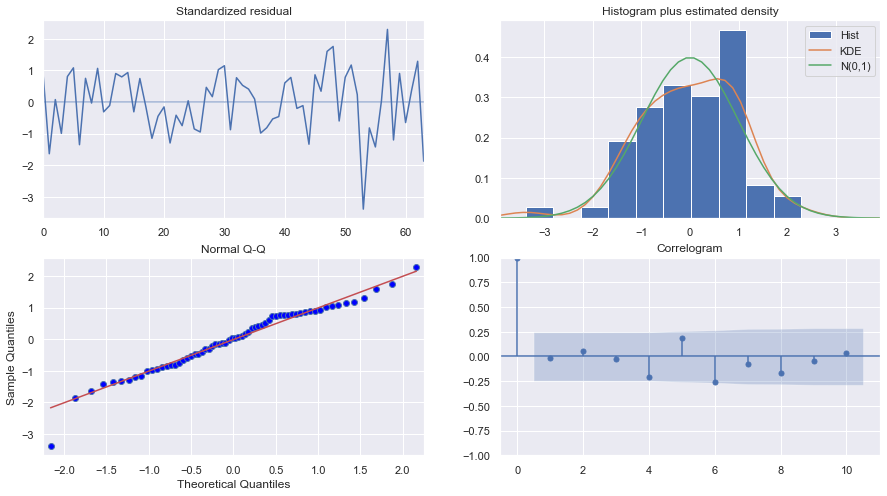

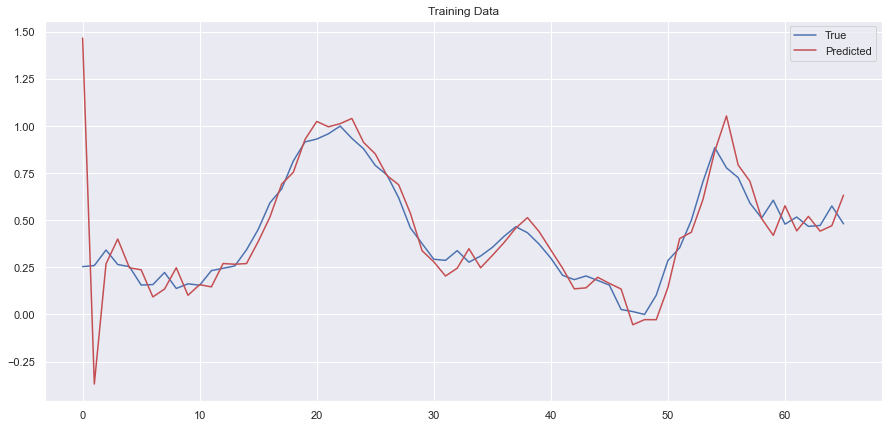

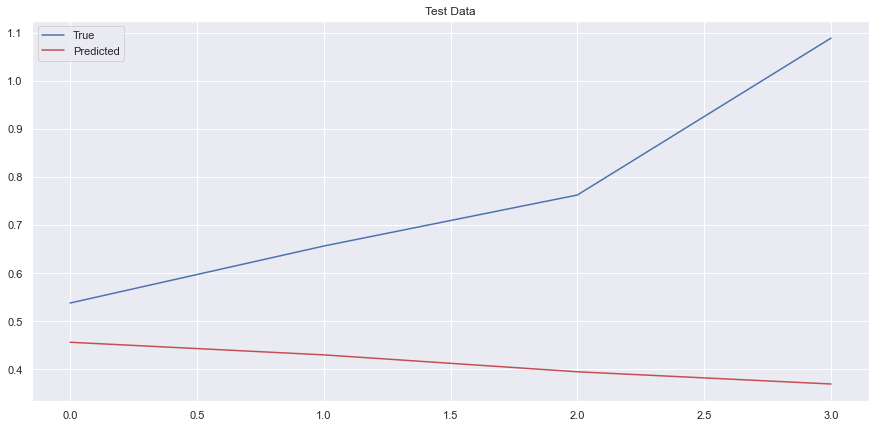

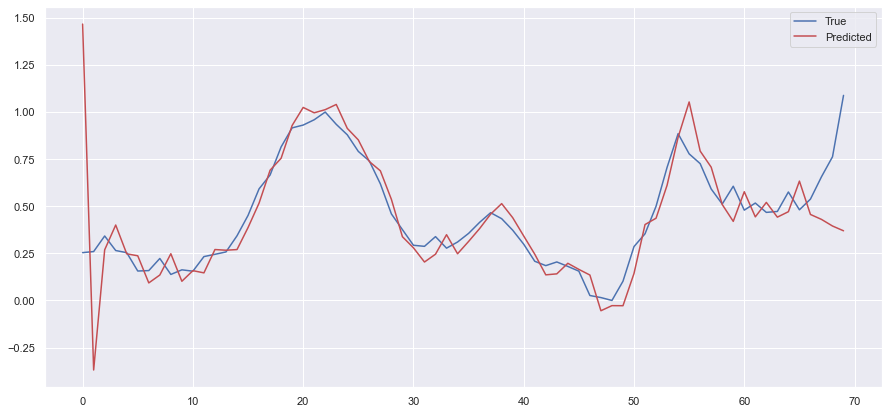

Training MAE: 0.09187945875868567
Test MAE: 0.34847046981494334


In [69]:
sarimax_parameter_pipe(hospital, covid_resample, state_cluster, 0)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-271.305, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-272.897, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-271.768, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-273.340, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-274.572, Time=0.09 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=-276.494, Time=0.12 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=-277.457, Time=0.19 sec
 ARIMA(6,2,0)(0,0,0)[0]             : AIC=-276.391, Time=0.22 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=-276.163, Time=0.22 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=-277.935, Time=0.20 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-274.211, Time=0.16 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=-275.486, Time=0.20 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-274.007, Time=0.19 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=-279.362, Time=0.32 sec
 ARIMA(6,2,2)(0,0,0)[0]          

C:\Users\blake\anaconda3\envs\capstone2_venv\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


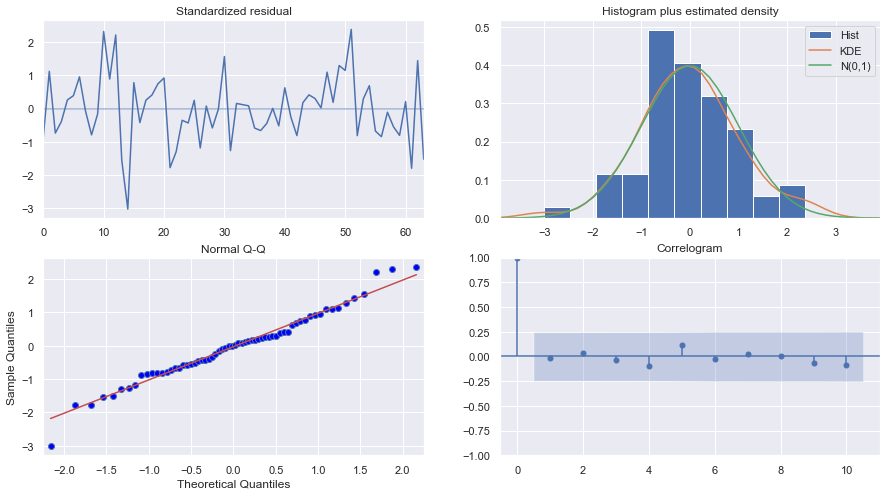

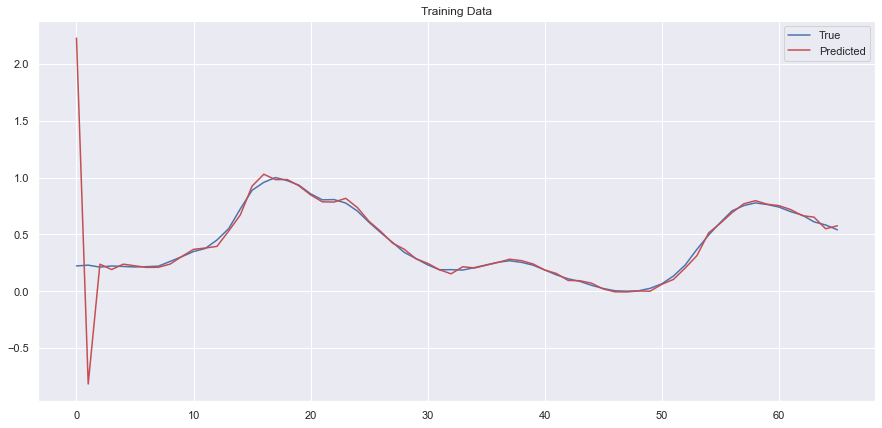

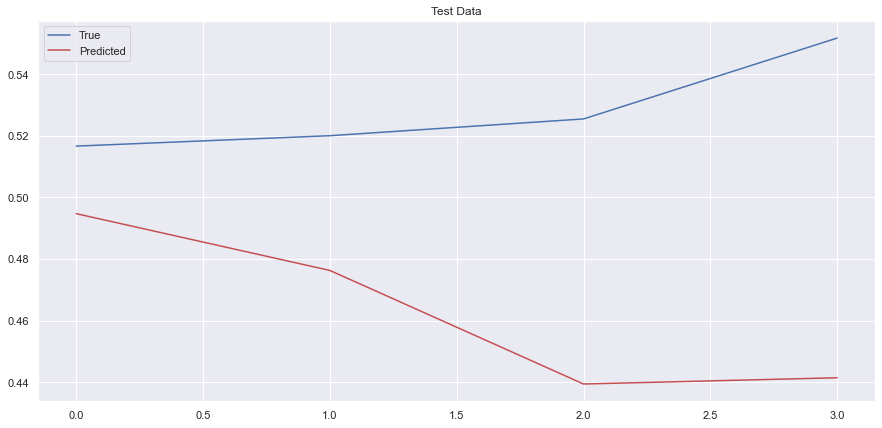

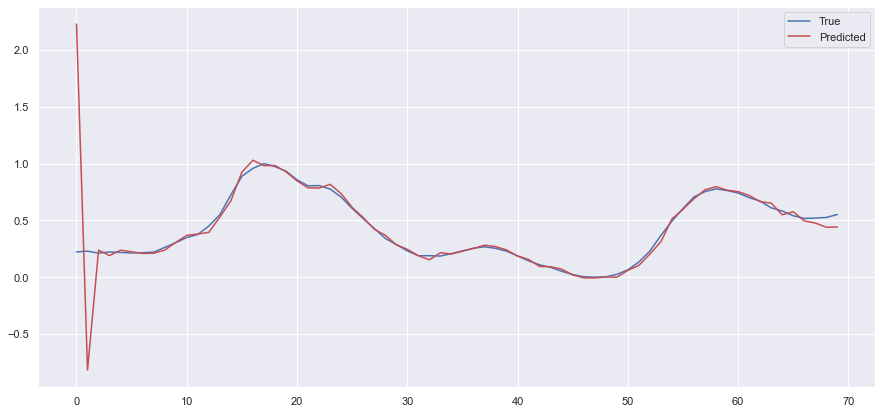

Training MAE: 0.0638938131356953
Test MAE: 0.06553392638438696


In [70]:
sarimax_parameter_pipe(hospital, covid_resample, state_cluster, 1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-159.516, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-268.699, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-212.442, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-161.510, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-276.664, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-286.438, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-284.825, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-285.057, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-285.145, Time=0.19 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-282.509, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-287.439, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-278.566, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-285.745, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-285.020, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]          

C:\Users\blake\anaconda3\envs\capstone2_venv\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   66
Model:               SARIMAX(3, 1, 0)   Log Likelihood                 148.719
Date:                Tue, 05 Apr 2022   AIC                           -287.439
Time:                        21:23:33   BIC                           -276.567
Sample:                             0   HQIC                          -283.149
                                 - 66                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.2166      0.706     -1.724      0.085      -2.600       0.167
ar.L1          1.0964      0.117      9.351      0.000       0.867       1.326
ar.L2          0.1301      0.180      0.723      0.4

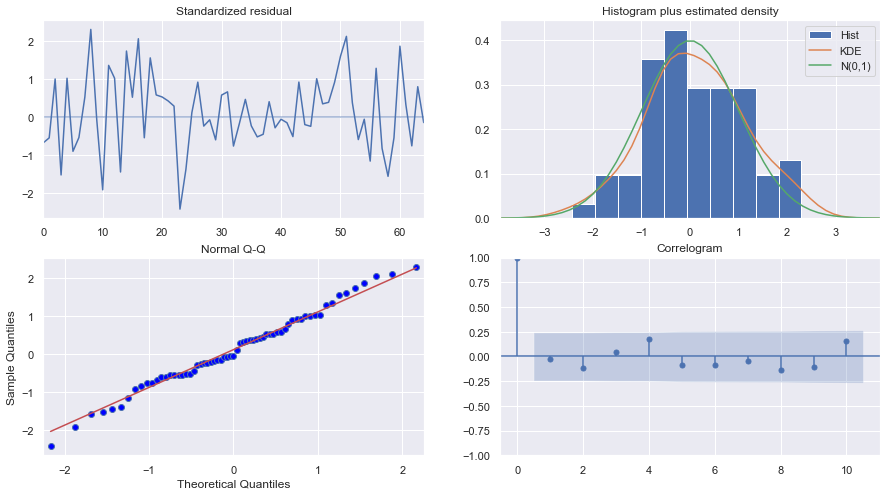

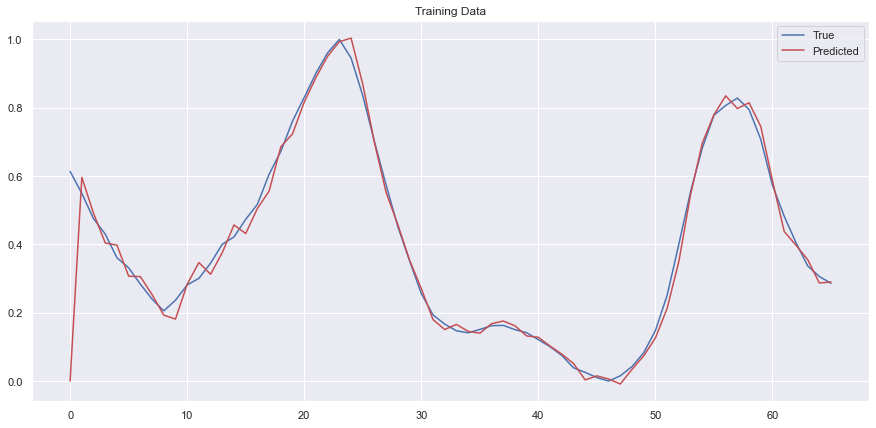

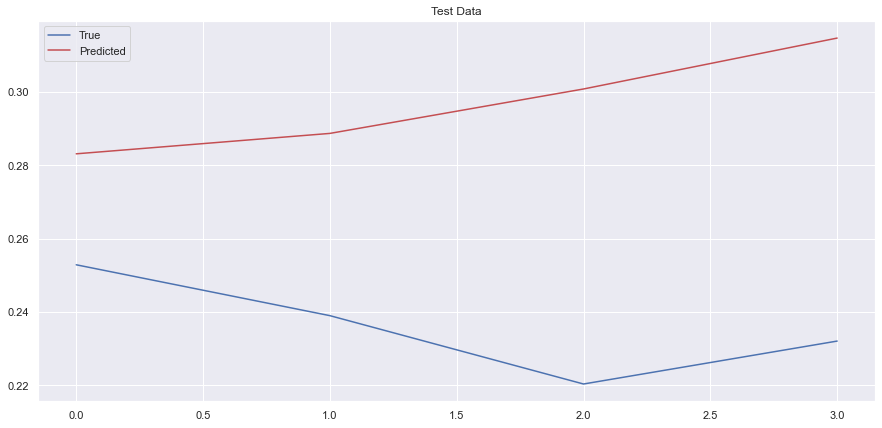

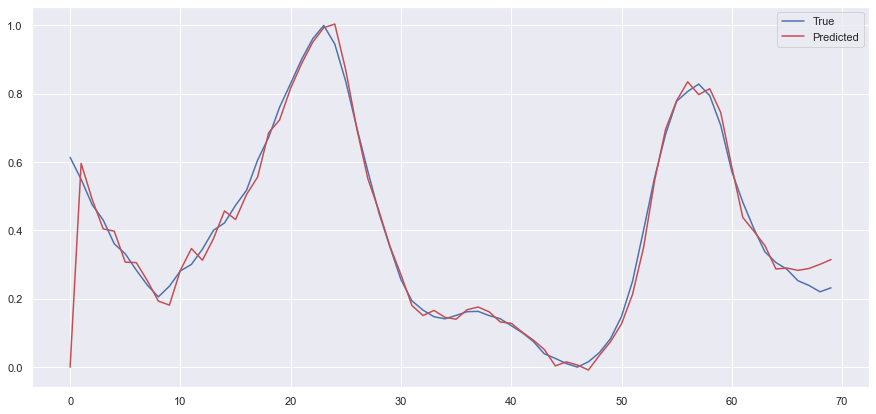

Training MAE: 0.028837288907337128
Test MAE: 0.06073296584006653


In [71]:
sarimax_parameter_pipe(hospital, covid_resample, state_cluster, 2)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-241.315, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-239.318, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-239.317, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-238.103, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-239.320, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.435 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   66
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 122.657
Date:                Tue, 05 Apr 2022   AIC                           -241.315
Time:                        21:24:06   BIC                           -236.997
Sample:                             0   HQIC                          -239.614
                                 - 66                                       

C:\Users\blake\anaconda3\envs\capstone2_venv\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


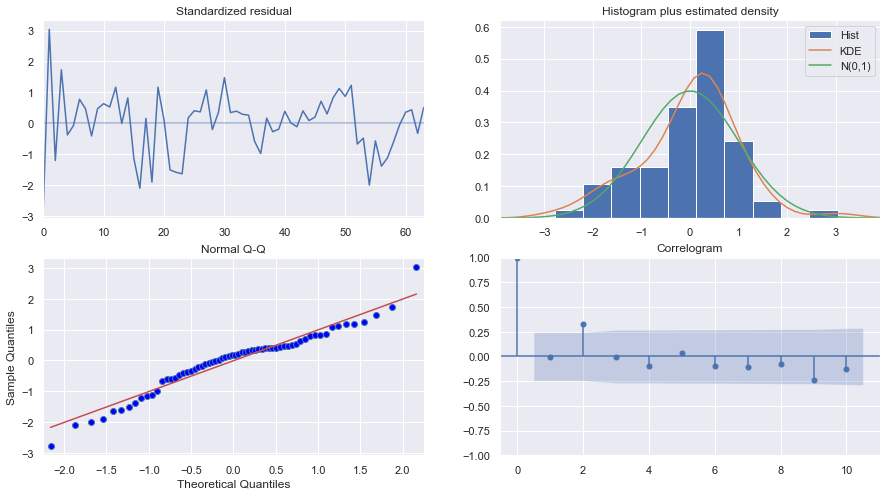

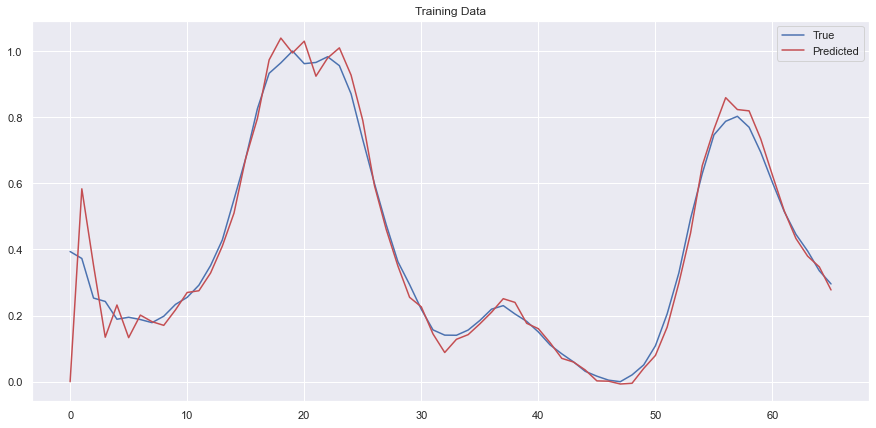

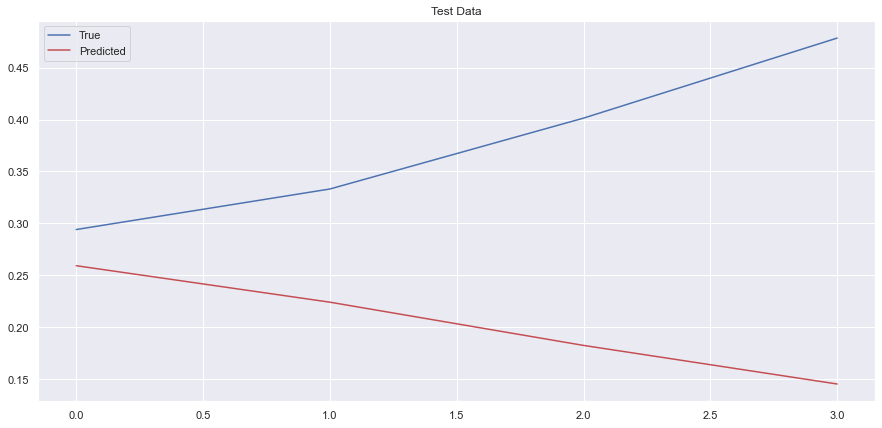

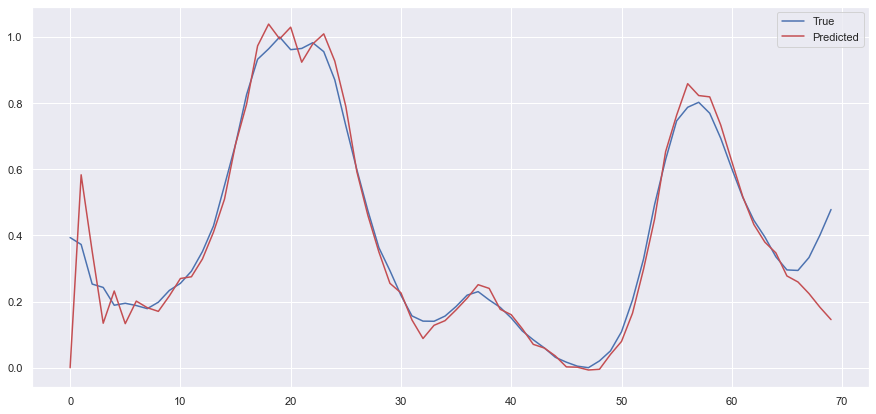

Training MAE: 0.03514238612053682
Test MAE: 0.17387083978120382


In [72]:
sarimax_parameter_pipe(hospital, covid_resample, state_cluster, 3)